### Prompt

Let’s imagine you work on the home team at Spotify. The product designer worked really hard on a new version of the home page, with the hope that it will lead to a higher conversion rate. The product manager told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of the user base.

In [2]:
import numpy as np
import pandas as pd

# probability distributions & statistical functions
import scipy.stats as stats

# estimating statistical models
import statsmodels.stats.api as sms

# libraries for plotting
import matplotlib.pyplot as plt
import seaborn as sns

# rounding function
from math import ceil



### Sample Size Calculation

Having set the power parameter to 0.8 in practice means that if there exists an actual difference in conversion rate between our designs, assuming the difference is the one we estimated (13% vs. 15%), we have about 80% chance to detect it as statistically significant in our test with the sample size we calculated.

In [3]:
effect_size = sms.proportion_effectsize(0.13, 0.15)    # Calculating effect size based on our expected rates
                                                        # Effect size for a test comparing two proportions


### Collecting and preparing the data

In [4]:
df = pd.read_csv('ab_data1.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,661590,2017-01-11 16:55:06,treatment,new_page,0
1,853541,2017-01-08 18:28:03,treatment,new_page,0
2,679687,2017-01-19 3:26:47,treatment,new_page,1
3,817355,2017-01-04 17:58:09,treatment,new_page,1
4,839785,2017-01-15 18:11:07,treatment,new_page,1


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294399 entries, 0 to 294398
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294399 non-null  int64 
 1   timestamp     294399 non-null  object
 2   group         294399 non-null  object
 3   landing_page  294399 non-null  object
 4   converted     294399 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


- user_id - The user ID of each session
- timestamp - Timestamp for the session
- group - Which group the user was assigned to for that session {control, treatment}
- landing_page - Which design each user saw on that session {old_page, new_page}
- converted - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

#### Before we go ahead and sample the data to get our subset, let’s make sure there are no users that have been sampled multiple times.

In [6]:
session_counts = df['user_id'].value_counts(ascending=False)
multi_users = session_counts[session_counts > 1].count()

print(multi_users)

3815


#### There are 3815 users that appear more than once. Since the number is pretty low, we’ll go ahead and remove them from the DataFrame to avoid sampling the same users twice.

In [7]:
users_to_drop = session_counts[session_counts > 1].index

df = df[~df['user_id'].isin(users_to_drop)]
print(df.shape[0])

286769


In [13]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143340
treatment,143429,0


In [14]:
#get rid of users who appeared in the wrong test group 

df_control = df.loc[(df['group'] == 'control')]
df_control = df_control[df.landing_page != 'new_page']

df_treat = df.loc[(df['group'] == 'treatment')]
df_treat = df_treat[df.landing_page != 'old_page']

df_clean = pd.concat([df_control, df_treat], ignore_index=True)
df = df_clean

<ipython-input-14-eaa72baabbce>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_control = df_control[df.landing_page != 'new_page']
<ipython-input-14-eaa72baabbce>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_treat = df_treat[df.landing_page != 'old_page']


In [15]:
# To make sure all the control group are seeing the old page and viceversa
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143340
treatment,143429,0


#### Now that our DataFrame is nice and clean, we can proceed and sample n=4720 entries for each of the groups. We can use pandas' DataFrame.sample() method to do this, which will perform Simple Random Sampling for us.

In [16]:
control_sample = df[df['group'] == 'control'].sample(n=required_n, random_state=22)
treatment_sample = df[df['group'] == 'treatment'].sample(n=required_n, random_state=22)



NameError: name 'required_n' is not defined

In [13]:
ab_test = pd.concat([control_sample, treatment_sample], axis=0)
ab_test.reset_index(drop=True, inplace=True)
ab_test

,user_id,timestamp,group,landing_page,converted
0,872964,2017-01-06 18:52:16,control,old_page,0
1,684934,2017-01-13 1:20:01,control,old_page,0
2,911614,2017-01-22 11:59:08,control,old_page,0
3,904388,2017-01-14 9:10:12,control,old_page,0
4,873162,2017-01-13 19:39:47,control,old_page,0
...,...,...,...,...,...
9435,863946,2017-01-17 1:56:33,treatment,new_page,0
9436,856048,2017-01-19 14:37:58,treatment,new_page,0
9437,778565,2017-01-10 9:41:16,treatment,new_page,0
9438,769342,2017-01-13 22:39:50,treatment,new_page,0


In [14]:
ab_test['group'].value_counts()


control      4720
treatment    4720
Name: group, dtype: int64

### Analysis Visualization

In [16]:
conversion_rates = ab_test.groupby('group')['converted']

std_p = lambda x: np.std(x)              # compute the std. deviation of the proportion
se_p = lambda x: stats.sem(x)            # compute the std error of the proportion (std / sqrt(n))

conversion_rates = conversion_rates.agg([np.mean, std_p, se_p])
conversion_rates.columns = ['conversion_rate', 'std_deviation', 'std_error']


conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.126,0.332,0.005
treatment,0.144,0.351,0.005


#### Judging by the stats above, it does look like our two designs performed very similarly, with our new design performing slightly better, approx. 12.6% vs. 14.4% conversion rate.


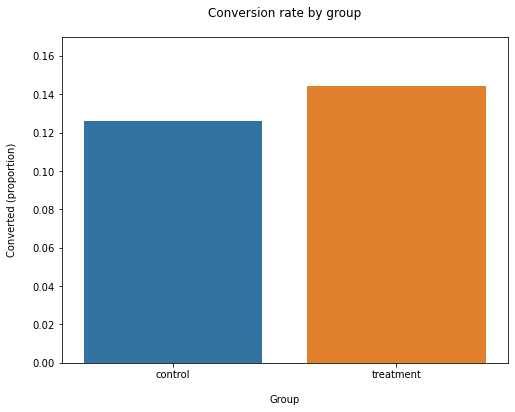

In [17]:
plt.figure(figsize=(8,6))

sns.barplot(x=ab_test['group'], y=ab_test['converted'], ci=False)

plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15);

### Testing for Stat Sig

#### Python makes all the calculations very easy. We can use the statsmodels.stats.proportion module to get the p-value and confidence intervals

In [18]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = ab_test[ab_test['group'] == 'control']['converted']
treatment_results = ab_test[ab_test['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()

successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

print(n_con)
print(n_treat)
print(successes)
print(nobs)

4720
4720
[595, 681]
[4720, 4720]


In [19]:
z_stat, pval = proportions_ztest(successes, nobs=nobs) #Test for proportions based on normal ztest
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05) #confidence interval for a binomial proportion


In [20]:
print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')

z statistic: -2.59
p-value: 0.010
ci 95% for control group: [0.117, 0.136]
ci 95% for treatment group: [0.134, 0.154]


#### Since our p-value=0.010 is below our α=0.05 threshold, we can reject the Null hypothesis Hₒ, which means that our new design did  perform significantly better than our old one

In [176]:
conversion_rates.style.format('{:.3f}')

,conversion_rate,std_deviation,std_error
group,,,
control,0.126,0.332,0.005
treatment,0.144,0.351,0.005


#### If we look at the confidence interval for the treatment group ([0.134, 0.154], or 13.4-15.4%) we notice that:
- It does include our target value of 15% (the 2% uplift we were aiming for)